In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option("display.max_rows", 10)

import re

import cleantext

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words

from autocorrect import Speller
spell = Speller(lang='en')
spell = Speller()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize


from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Lists for the reviews
review_corpus = []
review_corpus_cleaned = []
review_corpus_cleaned_split = []

# Vairables
review_counter = 0

# Function to write the reviews to a list
def write_reviews_to_corpus():
    
    print("Writing reviews to corpus...")

    # Opening and reading the dataset_reviews text file
    dataset_reviews = open("dataset_reviews.txt", "r", encoding='utf-8')
    review_text = dataset_reviews.read()
    dataset_reviews.close()

    # Vairables for writing the reviews to a list
    review_start = 0
    review_end = 0
    review_text_remove = ""
    global review_counter

    # Counting the number of reviews
    review_counter = review_text.count("}")

    # A for-loop writing each review to the list
    for i in range(review_counter):

        # For finding where each new review starts and ends
        review_start = review_text.find("{")
        review_end = review_text.find("}")

        # Adding the review to the list found between the start and end point
        review_corpus.append(review_text[(review_start + 1):review_end])

        # Assigning the review just read to the list to be removed form the review_text variable
        review_text_remove =  review_text[(review_start):review_end] + "}"

        # Removing the review just read to the list from the review_text variable
        review_text = review_text.replace( review_text_remove  , "")

    # Removing all the empty elements in the list
    while("" in review_corpus):
        review_corpus.remove("")

    # Updating review_counter
    review_counter = len(review_corpus)

In [3]:
# Function to apply text cleaning techniques to each element in the list
def clean_reviews_in_corpus():

    print("Cleaning reviews in corpus...")
    
    # Function to remove emoticons and other symbols from the text with the help of the Regular Expression library
    def remove_emoji(string):
            emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030"
            "]+", flags=re.UNICODE)
            
            return emoji_pattern.sub(r' ', string)
        
    # Function to remove user metions, URLs, hashtags and emoji's from the text with the help of the Regular Expression library
    def remove_unwanted_elements_with_re(string):

            # remove user mentions
            string = re.sub("@[A-Za-z0-9_]+"," ", string)
            # remove URLS
            string = re.sub(r'http\S+', ' ', string)
            # remove hashtags
            string = re.sub("#[A-Za-z0-9_]+","", string)
            # remove emoji's
            string = remove_emoji(string)
        
            return string.strip()
    
    # Function to apply lemmatization with part of speech tagging to each word in every review
    def apply_lemmatization_with_POS(string):

        lemmatizer = WordNetLemmatizer()
        
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None

        pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))  
        
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
        
        lemmatized_sentence = []

        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else: 
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

        lemmatized_sentence = " ".join(lemmatized_sentence)
        
        return lemmatized_sentence

    # Function to remove all the non-enlgish words from each review
    def remove_non_english_words(string):
         
        english_words = set(words.words())
       
        find_unique_words = re.findall(r'\b\w+\b', string)

        filtered_words = [word for word in find_unique_words if word in english_words]

        cleaned_text = ' '.join(filtered_words)

        return cleaned_text
    
    # Function to remove some Afrikaans words the remove_non_english_words function did not remove
    def remove_all_afrikaans_words(string):

        afrikaans_words = ['die', 'het', 'en', 'van', 'wat', 'toe', 'dit', 'om', 'te']

        find_unique_words = re.findall(r'\b\w+\b', string)
    
        filtered_words = [word for word in find_unique_words if word not in afrikaans_words]
        
        cleaned_text = ' '.join(filtered_words)
        
        return cleaned_text

    # Applying text cleaning techniques to each review in the list
    for i in range(review_counter):

        # Applying text cleaning techniques such as converting the text to lowercase, removing extra spaces, punctuation marks, numbers and removing stopwords with the cleantext library
        # Writing the cleaned text to the review_corpus_cleaned list
        review_corpus_cleaned.append(cleantext.clean(review_corpus[i], lowercase= True, extra_spaces= True, punct= True, numbers= True, stopwords= True, stp_lang= "English"))

        # Removing unwanted elements from each review such as user metions, URLs, hashtags and emoji's and other elemments with the removing_unwanted_elements_with_re() function
        review_corpus_cleaned[i] = remove_unwanted_elements_with_re(review_corpus_cleaned[i])

        # Correcting potentially misspelled words in each review with the autocorrect library
        review_corpus_cleaned[i]= spell.autocorrect_sentence(review_corpus_cleaned[i])
        
        # Removing all non-english words from each review
        review_corpus_cleaned[i] = remove_non_english_words(review_corpus_cleaned[i])
        
        # Function to remove some Afrikaans words the remove_non_english_words function did not remove
        review_corpus_cleaned[i] = remove_all_afrikaans_words(review_corpus_cleaned[i])

        # Applying lemmatization to each review with the nltk library
        review_corpus_cleaned[i] = apply_lemmatization_with_POS(review_corpus_cleaned[i])

    # Splitting each review in review_corpus_cleaned into its individual words
    for i in range(review_counter):
        review_corpus_cleaned_split.append(review_corpus_cleaned[i].split())

In [4]:
# Function to convert each review into a numercial vectors in three different ways
def convert_reviews_into_numerical_vectors():

    print("Converting reviews into numerical vectors...")
    # Function to convert each review into a numerical vector with the Bag-of-Words approach
    def BOW_vectorize():
        
        global BOW_vect
        BOW_vect = CountVectorizer()
  
        global BOW_data 
        BOW_data = BOW_vect.fit_transform(review_corpus_cleaned)
        
        df = pd.DataFrame(BOW_data.toarray(), columns=BOW_vect.get_feature_names_out())

        display(df)
    
    # Function to convert each review into a numerical vector with the Term-Frequency Inverse-Document-Frequency approach
    def TF_IDF_vectorize():
        
        global TF_IDF_vect
        TF_IDF_vect = TfidfVectorizer()

        global TF_IDF_data 
        TF_IDF_data = TF_IDF_vect.fit_transform(review_corpus_cleaned)
        
        df = pd.DataFrame(TF_IDF_data.toarray(), columns=TF_IDF_vect.get_feature_names_out())
        
        display(df)
    
    print("\nNumerical vector representation of the text using BoW:")
    BOW_vectorize()
    
    print("Numerical vector representation of the text using TF-IDF:")
    TF_IDF_vectorize()

In [5]:
def user_input_for_review():
    global review_view_num
    review_view_num = int(input(f"There are {review_counter} reviews in the corpus. Enter the number of the review to view which topic it is about. Enter 0 to skip:")) -1


In [6]:
# Function to calculate the optimal number of topics to extract using coherence scores for LSA using BoW
def coherence_scores_optimal_num_topics_LSA_using_BoW():

    def calculate_coherence_values(texts, num_topics_range, BOW_vect, BOW_data):
        print("Calculating coherence scores...")
        print("Calculating optimal number of topics...")
        print("Extracting topics...")


        coherence_scores = []
    
        for num_topics in num_topics_range:
            # Apply LSA (Truncated SVD in sklearn)
            lsa_model = TruncatedSVD(n_components=num_topics,  random_state=42)
            lsa_model.fit_transform(BOW_data)
            
            # Get topics (terms most associated with components)
            terms = BOW_vect.get_feature_names_out()
            topics = [[terms[i] for i in lsa_model.components_[j].argsort()[-10:]] for j in range(num_topics)]
            
            # Create a Gensim Dictionary and Corpus
            dictionary = Dictionary(texts)
            corpus = [dictionary.doc2bow(text) for text in texts]
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            
            coherence_scores.append(coherence_score)
        
        return coherence_scores     
    
    # Define range of number of topics
    num_topics_range = range(2, 10)

    # Calculate coherence scores for different numbers of topics
    coherence_scores = calculate_coherence_values(review_corpus_cleaned_split, num_topics_range, BOW_vect, BOW_data)

    # Plot coherence scores
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics for LSA using BoW")
    plt.show()

    # Find the optimal number of topics (max coherence score)
    global optimal_num_topics_LSA
    optimal_num_topics_LSA = num_topics_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics to extract for LSA using BoW: {optimal_num_topics_LSA}")


In [7]:
# Function to calculate the optimal number of topics to extract using coherence scores for LSA using TF-IDF
def coherence_scores_optimal_num_topics_LSA_using_TF_IDF():
   
    def calculate_coherence_values(texts, num_topics_range, TF_IDF_vect, TF_IDF_data):
    
        coherence_scores = []
    
        for num_topics in num_topics_range:
            # Apply LSA (Truncated SVD in sklearn)
            lsa_model = TruncatedSVD(n_components=num_topics,  random_state=42)
            lsa_model.fit_transform(TF_IDF_data)
            
            # Get topics (terms most associated with components)
            terms = TF_IDF_vect.get_feature_names_out()
            topics = [[terms[i] for i in lsa_model.components_[j].argsort()[-10:]] for j in range(num_topics)]
            
            # Create a Gensim Dictionary and Corpus
            dictionary = Dictionary(texts)
            corpus = [dictionary.doc2bow(text) for text in texts]
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            
            coherence_scores.append(coherence_score)
        
        return coherence_scores     
    
    # Define range of number of topics
    num_topics_range = range(2, 10)

    # Calculate coherence scores for different numbers of topics
    coherence_scores = calculate_coherence_values(review_corpus_cleaned_split, num_topics_range, TF_IDF_vect, TF_IDF_data)

    # Plot coherence scores
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics for LSA using TF-IDF")
    plt.show()

    # Find the optimal number of topics (max coherence score)
    global optimal_num_topics_LSA_using_TF_IDF
    optimal_num_topics_LSA_using_TF_IDF = num_topics_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics to extract for LSA using TF-IDF: {optimal_num_topics_LSA_using_TF_IDF}")

In [8]:
# Function to calculate the optimal number of topics to extract using coherence scores for LDA using BoW
def coherence_scores_optimal_num_topics_LDA_using_BoW():
    
    def calculate_coherence_values(texts, num_topics_range, BoW_vect, BoW_data):
    
        coherence_scores = []
    
        for num_topics in num_topics_range:
            
            # Apply LDA
            lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
            lda_model.fit_transform(BoW_data)
            
            # Get topics (terms most associated with components)
            terms = BoW_vect.get_feature_names_out()
            topics = [[terms[i] for i in lda_model.components_[j].argsort()[-10:]] for j in range(num_topics)]
            
            # Create a Gensim Dictionary and Corpus
            dictionary = Dictionary(texts)
            corpus = [dictionary.doc2bow(text) for text in texts]
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            
            coherence_scores.append(coherence_score)
        
        return coherence_scores     
    
    # Define range of number of topics
    num_topics_range = range(2, 10)

    # Calculate coherence scores for different numbers of topics
    coherence_scores = calculate_coherence_values(review_corpus_cleaned_split, num_topics_range, BOW_vect, BOW_data)

    # Plot coherence scores
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics for LDA using BoW")
    plt.show()

    # Find the optimal number of topics (max coherence score)
    global optimal_num_topics_LDA_using_BoW
    optimal_num_topics_LDA_using_BoW = num_topics_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics to extract for LDA using BoW: {optimal_num_topics_LDA_using_BoW}")

In [9]:
# Function to calculate the optimal number of topics to extract using coherence scores for LDA using TF-IDF
def coherence_scores_optimal_num_topics_LDA_using_TF_IDF():
   
    def calculate_coherence_values(texts, num_topics_range, TF_IDF_vect, TF_IDF_data):
    
        coherence_scores = []
    
        for num_topics in num_topics_range:
            
            # Apply LDA
            lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
            lda_model.fit_transform(TF_IDF_data)
            
            # Get topics (terms most associated with components)
            terms = TF_IDF_vect.get_feature_names_out()
            topics = [[terms[i] for i in lda_model.components_[j].argsort()[-10:]] for j in range(num_topics)]
            
            # Create a Gensim Dictionary and Corpus
            dictionary = Dictionary(texts)
            corpus = [dictionary.doc2bow(text) for text in texts]
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            
            coherence_scores.append(coherence_score)
        
        return coherence_scores     
    
    # Define range of number of topics
    num_topics_range = range(2, 10)

    # Calculate coherence scores for different numbers of topics
    coherence_scores = calculate_coherence_values(review_corpus_cleaned_split, num_topics_range, TF_IDF_vect, TF_IDF_data)

    # Plot coherence scores
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics for LDA using TF-IDF")
    plt.show()

    # Find the optimal number of topics (max coherence score)
    global optimal_num_topics_LDA_using_TF_IDF
    optimal_num_topics_LDA_using_TF_IDF = num_topics_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics to extract for LDA using TF-IDF: {optimal_num_topics_LDA_using_TF_IDF}")

In [10]:
def topic_extraction_with_LSA_using_BoW():
    
    # Apply Latent Semantic Analysis (using Truncated SVD)
    lsa_BoW_model = TruncatedSVD(n_components=optimal_num_topics_LSA, random_state=42) 
    lsa_BoW_model.fit_transform(BOW_data)

    terms = BOW_vect.get_feature_names_out()

    print("\nTopics extracted from the text using LSA with BoW:")
    for i, comp in enumerate(lsa_BoW_model.components_):
        terms_in_topic = [terms[j] for j in comp.argsort()[:-11:-1]]  # Top 10 words per topic
        print(f"Topic {i+1}: {', '.join(terms_in_topic)}")

    if 0 < review_view_num < review_counter:

        lsa_model_normalized = lsa_BoW_model.fit_transform(BOW_data)
        lsa_model_normalized = normalize(lsa_model_normalized)

        topic = np.argmax(lsa_model_normalized[review_view_num])
        print(f"\nReview {review_view_num + 1} is about Topic {topic + 1}")
        print(f"Review {review_view_num + 1}: {review_corpus[review_view_num]}")

    elif review_view_num > review_counter:
        print("\nSkipping... Review number not found.")


In [11]:
def topic_extraction_with_LSA_using_TF_IDF():

    # Apply Latent Semantic Analysis (using Truncated SVD)
    lsa_TF_IDF_model = TruncatedSVD(n_components=optimal_num_topics_LSA_using_TF_IDF, random_state=42) 
    lsa_TF_IDF_model.fit_transform(TF_IDF_data)
    
    terms = TF_IDF_vect.get_feature_names_out()

    print("\nTopics extracted from the text using LSA with TF-IDF:")
    for i, comp in enumerate(lsa_TF_IDF_model.components_):
        terms_in_topic = [terms[j] for j in comp.argsort()[:-11:-1]]  # Top 10 words per topic
        print(f"Topic {i+1}: {', '.join(terms_in_topic)}")

    if 0 < review_view_num < review_counter:
        
        lsa_model_normalized = lsa_TF_IDF_model.fit_transform(TF_IDF_data)
        lsa_model_normalized = normalize(lsa_model_normalized)

        topic = np.argmax(lsa_model_normalized[review_view_num])
        print(f"\nReview {review_view_num + 1} is about Topic {topic + 1}")
        print(f"Review {review_view_num + 1}: {review_corpus[review_view_num]}")
    
    elif review_view_num > review_counter:
        print("\nSkipping... Review number not found.")

In [12]:
def topic_extraction_with_LDA_using_BoW():

    # Apply LDA
    lda_BoW_model = LatentDirichletAllocation(n_components=optimal_num_topics_LDA_using_BoW, random_state=42)
    lda_BoW_model.fit_transform(BOW_data)
    
    terms = BOW_vect.get_feature_names_out()
    
    print("\nTopics extracted from the text using LDA with BoW:")
    for i, comp in enumerate(lda_BoW_model.components_):
        terms_in_topic = [terms[j] for j in comp.argsort()[:-11:-1]]  # Top 10 words per topic
        print(f"Topic {i+1}: {', '.join(terms_in_topic)}")
    
    if 0 < review_view_num < review_counter:

        lda_model_normalized = lda_BoW_model.fit_transform(BOW_data)
        lda_model_normalized = normalize(lda_model_normalized)

        topic = np.argmax(lda_model_normalized[review_view_num])
        print(f"\nReview {review_view_num + 1} is about Topic {topic + 1}")
        print(f"Review {review_view_num + 1}: {review_corpus[review_view_num]}")
    
    elif review_view_num > review_counter:
        print("\nSkipping... Review number not found.")

In [13]:
def topic_extraction_with_LDA_using_TF_IDF():

    # Apply LDA
    lda_TF_IDF_model = LatentDirichletAllocation(n_components=optimal_num_topics_LDA_using_TF_IDF, random_state=42)
    lda_TF_IDF_model.fit_transform(TF_IDF_data)
    
    terms = TF_IDF_vect.get_feature_names_out()

    print("\nTopics extracted from the text using LDA with TF-IDF:")
    for i, comp in enumerate(lda_TF_IDF_model.components_):
        terms_in_topic = [terms[j] for j in comp.argsort()[:-11:-1]]  # Top 10 words per topic
        print(f"Topic {i+1}: {', '.join(terms_in_topic)}")
    
    if 0 < review_view_num < review_counter:

        lda_model_normalized = lda_TF_IDF_model.fit_transform(TF_IDF_data)
        lda_model_normalized = normalize(lda_model_normalized)

        topic = np.argmax(lda_model_normalized[review_view_num])
        print(f"\nReview {review_view_num + 1} is about Topic {topic + 1}")
        print(f"Review {review_view_num + 1}: {review_corpus[review_view_num]}")
    
    elif review_view_num > review_counter:
        print("\nSkipping... Review number not found.")

    print("\nTopic Extraction Done.")
    

Writing reviews to corpus...
Cleaning reviews in corpus...
Converting reviews into numerical vectors...

Numerical vector representation of the text using BoW:


,abhorrent,abide,ability,ablation,able,...,yr,zar,zero,zimbabwe,zone
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1020,0,0,0,0,1,...,0,0,0,0,0
1021,0,0,0,0,0,...,0,0,0,0,0
1022,0,0,0,0,0,...,0,0,0,0,0
1023,0,0,0,0,0,...,0,0,0,0,0


Numerical vector representation of the text using TF-IDF:


,abhorrent,abide,ability,ablation,able,...,yr,zar,zero,zimbabwe,zone
0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,0.0,0.0,0.0,0.261521,...,0.0,0.0,0.0,0.0,0.0
1021,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
1023,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0


Calculating coherence scores...
Calculating optimal number of topics...
Extracting topics...


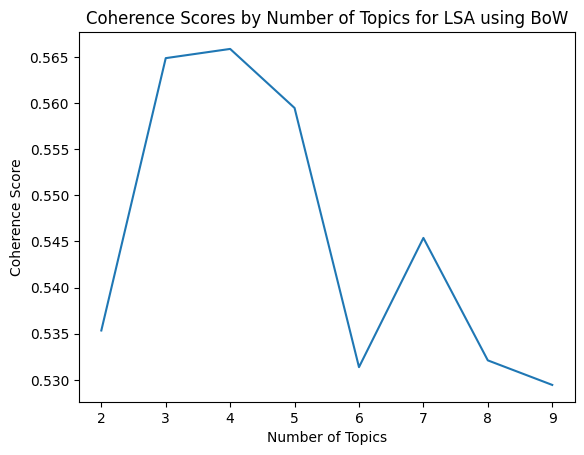

Optimal number of topics to extract for LSA using BoW: 4

Topics extracted from the text using LSA with BoW:
Topic 1: water, day, meter, urgent, cell, still, ref, send, good, without
Topic 2: city, get, cape, meter, town, receive, pay, tell, time, electricity
Topic 3: meter, receive, municipality, property, electricity, access, mail, department, account, municipal
Topic 4: water, meter, bill, pay, leak, month, city, fix, log, cost

Review 800 is about Topic 1
Review 800: <p>Dear Sir Madame </p>

<p><br />Reason for my email is a complaint again the City of Cape Town water department. </p>

<p>For bad standard service </p>

<p>Failure to keep an appointment</p>

<p>Today is the third day my family has been without water. I first contacted the CCT water department on 05 Jan 2017 at 09H20 and got ref :  ********** 785 and by the evening nobody responded , I have made numerous calls , I have used all ways of communication, emails, twitter , sms and online and I have all the proof on my pho

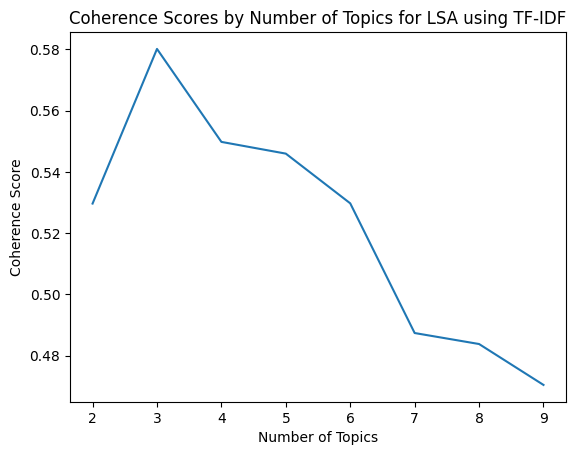

Optimal number of topics to extract for LSA using TF-IDF: 3

Topics extracted from the text using LSA with TF-IDF:
Topic 1: water, city, meter, day, get, call, cape, town, come, service
Topic 2: water, meter, leak, bill, without, fix, supply, read, house, reading
Topic 3: account, bill, pay, month, amount, payment, receive, meter, make, money

Review 800 is about Topic 1
Review 800: <p>Dear Sir Madame </p>

<p><br />Reason for my email is a complaint again the City of Cape Town water department. </p>

<p>For bad standard service </p>

<p>Failure to keep an appointment</p>

<p>Today is the third day my family has been without water. I first contacted the CCT water department on 05 Jan 2017 at 09H20 and got ref :  ********** 785 and by the evening nobody responded , I have made numerous calls , I have used all ways of communication, emails, twitter , sms and online and I have all the proof on my phone.</p>

<p>Last night I was promised the contractor will fix the fault the night if not t

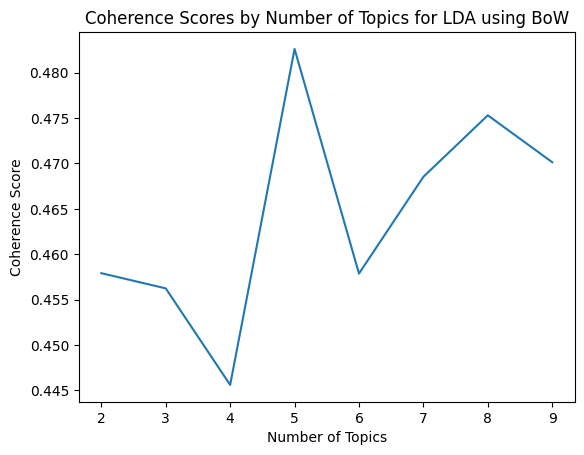

Optimal number of topics to extract for LDA using BoW: 5

Topics extracted from the text using LDA with BoW:
Topic 1: water, city, meter, day, come, call, cape, service, town, get
Topic 2: account, municipality, city, pay, go, make, get, property, electricity, us
Topic 3: electricity, account, city, pay, cape, town, go, get, power, still
Topic 4: get, tell, go, people, city, cape, would, service, call, time
Topic 5: water, day, ref, urgent, cell, send, good, without, still, date

Review 800 is about Topic 1
Review 800: <p>Dear Sir Madame </p>

<p><br />Reason for my email is a complaint again the City of Cape Town water department. </p>

<p>For bad standard service </p>

<p>Failure to keep an appointment</p>

<p>Today is the third day my family has been without water. I first contacted the CCT water department on 05 Jan 2017 at 09H20 and got ref :  ********** 785 and by the evening nobody responded , I have made numerous calls , I have used all ways of communication, emails, twitter , 

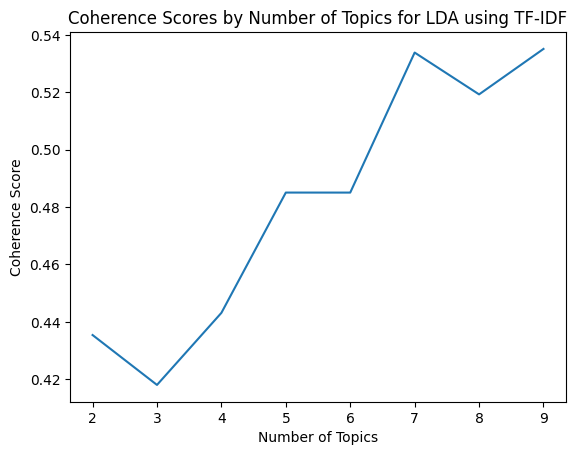

Optimal number of topics to extract for LDA using TF-IDF: 9

Topics extracted from the text using LDA with TF-IDF:
Topic 1: water, city, get, day, cape, service, call, town, meter, come
Topic 2: disgusting, operate, wormhole, spar, junta, spread, real, shame, mir, mosque
Topic 3: fair, beach, world, affidavit, probe, hell, northern, plea, drinking, humanity
Topic 4: zone, intersection, environmental, ticket, raise, shop, shout, wasted, needle, branch
Topic 5: tank, septic, replacement, ha, god, pleasant, prosper, sincere, login, pon
Topic 6: blow, music, bloodstock, thy, sweep, device, rise, easter, exist, input
Topic 7: bill, read, reading, actual, increase, arrangement, normal, water, account, month
Topic 8: enforcement, dig, accommodation, handle, major, enquiry, all, bus, sa, informative
Topic 9: disappoint, pool, ticket, dump, behind, encourage, landlord, community, theyre, ocean

Review 800 is about Topic 1
Review 800: <p>Dear Sir Madame </p>

<p><br />Reason for my email is a co

In [14]:

# Calling all the functions for review topic extraction
write_reviews_to_corpus()

clean_reviews_in_corpus()

convert_reviews_into_numerical_vectors()

user_input_for_review()

coherence_scores_optimal_num_topics_LSA_using_BoW()
topic_extraction_with_LSA_using_BoW()

coherence_scores_optimal_num_topics_LSA_using_TF_IDF()
topic_extraction_with_LSA_using_TF_IDF()

coherence_scores_optimal_num_topics_LDA_using_BoW()
topic_extraction_with_LDA_using_BoW()

coherence_scores_optimal_num_topics_LDA_using_TF_IDF()
topic_extraction_with_LDA_using_TF_IDF()
